In [13]:
from mussel_data.helpers import *

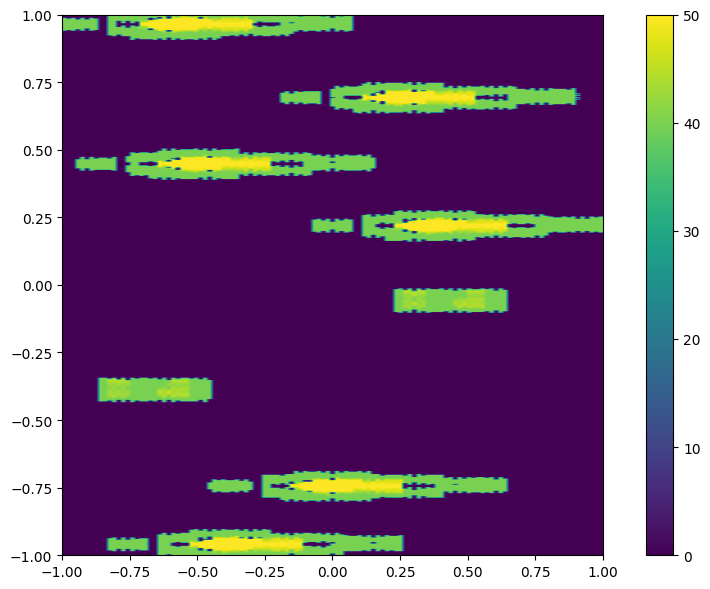

In [67]:
plot_raster(tif_name="Trial-bin_3")

In [14]:
bm_dens_col_name = "bm_dens"
bm_dens_bins = (
    Bin(bm_dens_col_name, 1, "First bin", 0, 20, simplekml.Color.yellow),
    Bin(bm_dens_col_name, 2, "Second bin", 20, 40, simplekml.Color.orange),
    Bin(bm_dens_col_name, 3, "Third bin", 40, 60, simplekml.Color.red, "[]"),
)

In [15]:
main_name = "only_bm_seg"
geo_df = open_shp_with_geopandas(file_name=main_name)
width, height = get_geodf_dimensions(geo_df=geo_df)

In [16]:
geo_df_bin_1 = geo_df[(geo_df[bm_dens_col_name] >= 0) & (geo_df[bm_dens_col_name] < 20)]
geo_df_bin_2 = geo_df[(geo_df[bm_dens_col_name] >= 20) & (geo_df[bm_dens_col_name] < 40)]
geo_df_bin_3 = geo_df[geo_df[bm_dens_col_name] >= 40]

In [33]:
geo_df_bin_1_b = open_shp_with_geopandas(file_name="only_bm_seg-bm_dens-bin_1")
geo_df_bin_2_b = open_shp_with_geopandas(file_name="only_bm_seg-bm_dens-bin_2")
geo_df_bin_3_b = open_shp_with_geopandas(file_name="only_bm_seg-bm_dens-bin_3")

In [26]:
save_geodataframe_to_shp(geo_df=geo_df_bin_1, file_name=main_name + "_bin_1")
save_geodataframe_to_shp(geo_df=geo_df_bin_2, file_name=main_name + "_bin_2")
save_geodataframe_to_shp(geo_df=geo_df_bin_3, file_name=main_name + "_bin_3")

In [53]:
main_name = "only_bm_seg-bm_dens-bin_3"
radius1_metres = 60
radius2_metres = 10
pixel_size = 10 #in metres
start_coord = [geo_df.total_bounds[0],geo_df.total_bounds[1]]
radius1_degrees, _ = coordinate_difference_in_metres_to_degrees(start_coord=start_coord,distance_in_metres=radius1_metres)
_, radies2_degrees = coordinate_difference_in_metres_to_degrees(start_coord=start_coord,distance_in_metres=radius2_metres, bearing=0)
target_column = bm_dens_col_name
new_main_name = main_name+"-"+target_column+"-"
print([main_name, target_column, radius1_degrees, radies2_degrees, width/pixel_size,height/pixel_size])
new_main_name_full = run_interpolation(
    input_shp_name=main_name,
    target_column=target_column,
    output_tif_name=new_main_name,
    algorithm="average",
    radius1=radius1_degrees,
    radius2=radies2_degrees,
    width=int(width/pixel_size),
    height=int(height/pixel_size),
)

['only_bm_seg-bm_dens-bin_3', 'bm_dens', 0.000986643099562201, 8.979930572650119e-05, 119.84356844269482, 708.3864931924033]


In [31]:
new_main_name_full

'only_bm_seg_bin_3-bm_dens-'

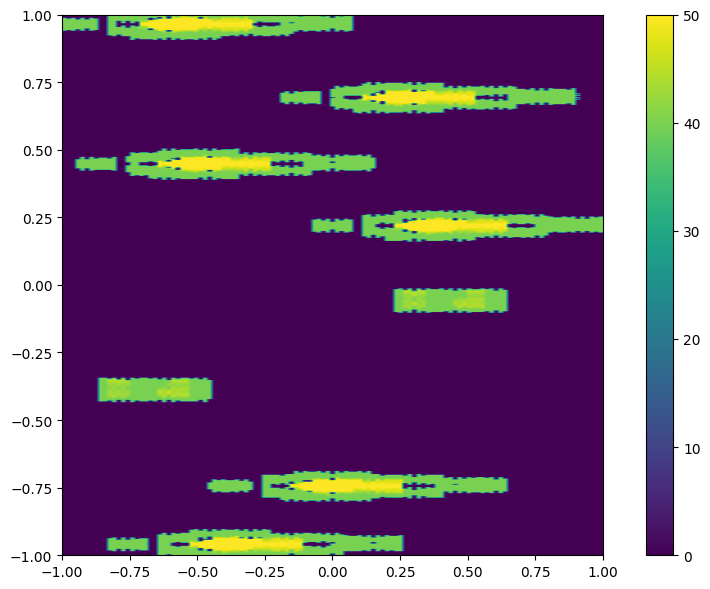

In [55]:
new_main_name_full = "Trial-bin_3"
plot_raster(tif_name=new_main_name_full)

Opened tif file from tif_files/only_bm_seg-bm_dens--average-986.6431.tif. Run plot_raster() to view
3.3333333333333335 0.0
6.666666666666667 3.3333333333333335
10.0 6.666666666666667
Saved tif to: tif_files/only_bm_seg-bm_dens--average-986.6431_binned.tif


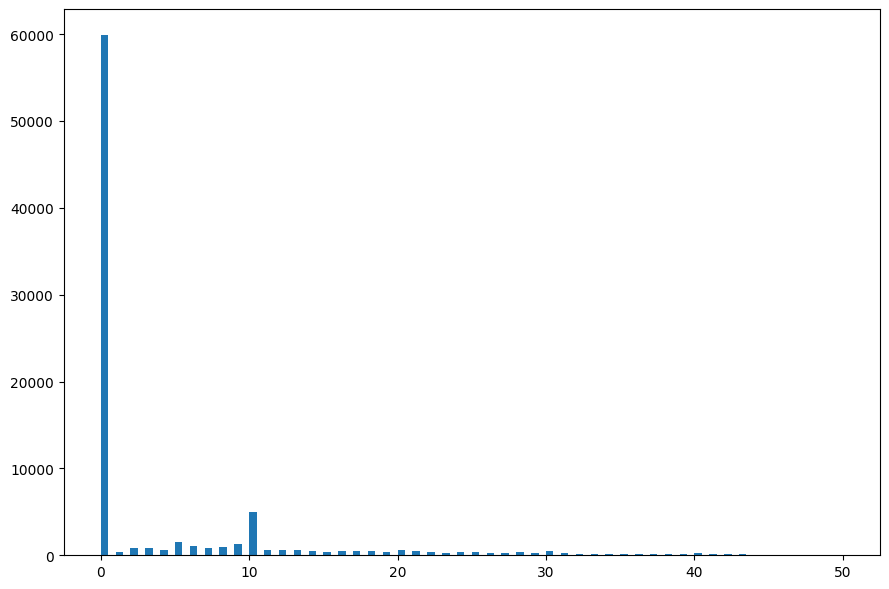

In [33]:
# new_main_name_full = "only_bm_seg-bm_dens--average-986.6431"
from osgeo import gdalconst
import numpy as np
def apply_bins_to_tif(file_name:str, bins:tuple[Bin], file_name_suffix:str="_binned") -> str:
    in_dataset = open_tif_with_gdal(file_name=file_name)
    if in_dataset is None:
        print("Could not open image file")
    
    in_band = in_dataset.GetRasterBand(1)
    rows = in_dataset.RasterYSize
    cols = in_dataset.RasterXSize

    # create the output image
    driver = in_dataset.GetDriver()
    in_band_as_array = in_band.ReadAsArray()
    
    # plot distribution of values in array
    plt.hist(in_band_as_array.flatten(), bins=100)

    for bin in bins:
        print(bin.upper_bound_norm, bin.lower_bound_norm)
        if bin.boundary_type == "[]":
            cond1 = (in_band_as_array <= bin.upper_bound_norm)         
        else:
            cond1 = (in_band_as_array < bin.upper_bound_norm)
        cond2 = (in_band_as_array >= bin.lower_bound_norm)
        in_band_as_array[cond1 & cond2] = bin.enum
        # get max value in all arrays

        
    # Create out dataset
    new_file_name = file_name + file_name_suffix
    new_file_path = TIF_PATH+new_file_name+".tif"
    out_dataset = driver.Create(new_file_path, cols, rows, 1, gdalconst.GDT_Byte)
    if out_dataset is None:
        print('Could not create output tif file')
    out_band = out_dataset.GetRasterBand(1)
    out_band_as_array = in_band_as_array
    out_band.WriteArray(out_band_as_array, 0, 0)

    # flush data to disk, set the NoData value and calculate stats
    out_band.FlushCache()
    print(f"Saved tif to: {TIF_PATH+file_name+file_name_suffix+'.tif'}")
    # out_band.SetNoDataValue(-99)

    # georeference the image and set the projection
    out_dataset.SetGeoTransform(in_dataset.GetGeoTransform())
    out_dataset.SetProjection(in_dataset.GetProjection())

    del out_dataset
    return new_file_name


new_main_name_full_binned = apply_bins_to_tif(file_name=new_main_name_full,bins=bm_dens_bins)

In [24]:
def print_nth_line_of_raster(file_name:str, line_number:int=0):
    in_dataset = open_tif_with_gdal(file_name=file_name)
    if in_dataset is None:
        print("Could not open image file")
    
    in_band = in_dataset.GetRasterBand(1)

    # out_data = np.zeros((rows,cols), np.int16)

    in_band_as_array = in_band.ReadAsArray()
    print(in_band_as_array[line_number])

line_number=345
print_nth_line_of_raster(file_name=new_main_name_full, line_number=line_number)

print_nth_line_of_raster(file_name=new_main_name_full+"_binned", line_number=line_number)

Opened tif file from tif_files/only_bm_seg-bm_dens--average-986.6431.tif. Run plot_raster() to view
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  2  3  5  5  7
  8  7  9  9 10  9 10  9  7  8  7  8  5  3  3  2  3  0  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16 16 16 16 22 25 26 36 28
 33 29 28 27 27 28 27 31 26 35 28 31 29 28 27 27 29 22 25 21 23 15 17 16
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Opened tif file from tif_files/only_bm_seg-bm_dens--average-986.6431_binned.tif. Run plot_raster() to view
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  3
  3  3  3  3  3  3  3  3  3  3  3  3  2  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 16 16 16 16 22 25 26 36 28
 33 29 28 27 27 28 27 31 26 35 28 31 29 28 27 27 29 22 25 21 23 15 17 16
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


Opened tif file from tif_files/only_bm_seg-bm_dens--average-986.6431_binned.tif. Run plot_raster() to view


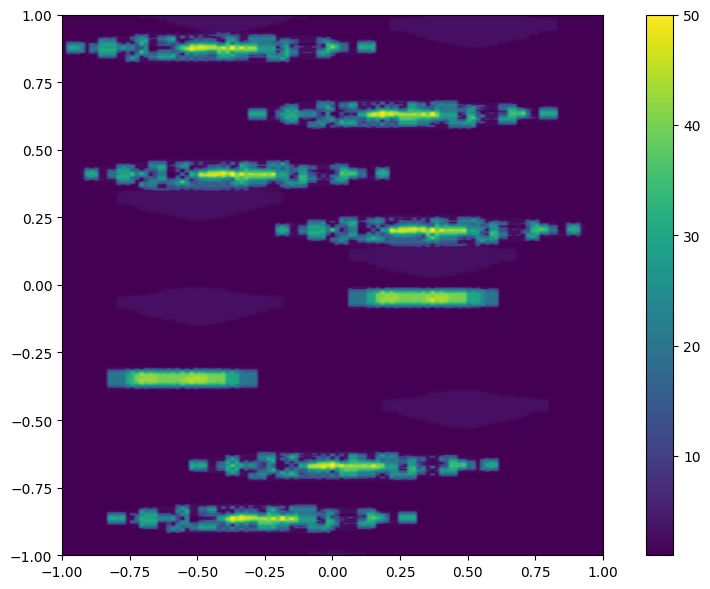

In [55]:
plot_raster(tif_name=new_main_name_full+"_binned")
new_main_name_full_binned = new_main_name_full+"_binned"

In [9]:
run_polygonize(
    input_tif=new_main_name_full,
    mask='none',
    options=["-mask",new_main_name_full])


In [10]:
polygon_df = open_shp_with_geopandas(file_name=new_main_name_full)

In [11]:
# select only DN rows greater that 0
polygon_df = polygon_df[polygon_df.DN > 0].copy()

In [12]:
polygon_df["DN"] = 2

In [13]:
temp_bins = [Bin(column="bm_dens",enum=2, description="TempBin3",lower=1,upper=60, boundary_type="[]", colour=simplekml.Color.blue)]

In [14]:
def unite_polygons_to_binned_multipolygon_dict(
    *, bins: tuple[Bin], geo_df: gp.GeoDataFrame = None, polygon_dict = None, grouping_col: str = None, target_column: str = None,
) -> dict[str, sp.MultiPolygon]:
    """
    Takes a geo_df containing polygons, unites any overlapping polygons and groups the
    resulting multipolygons into a binned dict.
    """
    multipolygon_dict = dict()
    for bin in bins:

        multipolygon_dict[bin.enum] = sp.unary_union(
            geo_df[geo_df[grouping_col] == bin.enum][target_column]
        )
        print(
            "Bin {}: uniting {} polygons to {} polygons".format(
                bin.enum, len(geo_df[geo_df[grouping_col] == bin.enum][target_column]), len(multipolygon_dict[bin.enum].geoms)
            )
        )
        # # If geo_df as input
        # column = geo_df[geo_df[grouping_col] == bin.enum][target_column]
        # multipolygon_dict[bin.enum] = sp.unary_union(
        #     geo_df[geo_df[grouping_col] == bin.enum][target_column]
        # )
        # print(
        #     "Bin {}: uniting {} polygons to {} polygons".format(
        #         bin.enum, len(column), len(multipolygon_dict[bin.enum].geoms)
        #     )
        # )
    return multipolygon_dict
poly_dict = unite_polygons_to_binned_multipolygon_dict(geo_df=polygon_df, bins=temp_bins, grouping_col="DN", target_column="geometry")

Bin 2: uniting 2461 polygons to 8 polygons


In [15]:
# make kml file
make_kml_from_binned_multipolygon_dict(binned_multipolygon_dict=poly_dict, file_name="Average_binned_polygonised", bins=bm_dens_bins, ignore_bin=[1,3])
